# **Image Classification with Convolutional Neural Networks (CNNs)**

Convolutional neural networks (CNNs) are commonly used in data science domain especially for computer vision and image classification tasks. Consider an image classification task. Images consist of pixels which are represented with numbers. In the convolution layer of CNNs, filters (or feature detectors) are applied to the image to extract distinctive features of the image by preserving the spatial relationships among pixels.

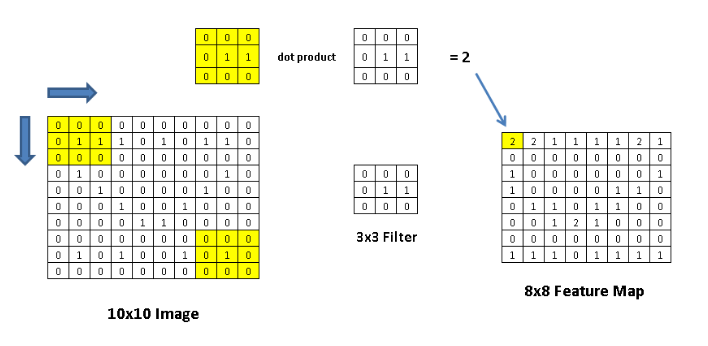

In a convolution layer, not just one filter is used. Many different filters are applied to the image. Each filter is aimed to capture a different feature such as edges, horizontol lines and so on.

Images are highly non-linear so we need to increase the non-linearity in convolution layer. In the convolution layer, rectifier function is applied to increase the non-linearity in the image. Rectifier function acts as an additional filter to break up linearity.

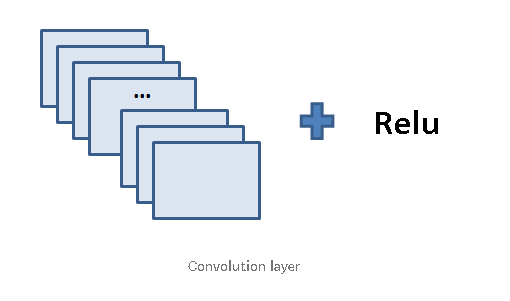

Then we have Pooling layer which reduces the size of the feature maps while maintaining the preserved features of the image.

In the pooling layer, a box with a specified size is captured and the maximum value in that box is taken. This is maximum pooling. We can also take the sum or mean of values in the box. This box scans through the entire feature map. 

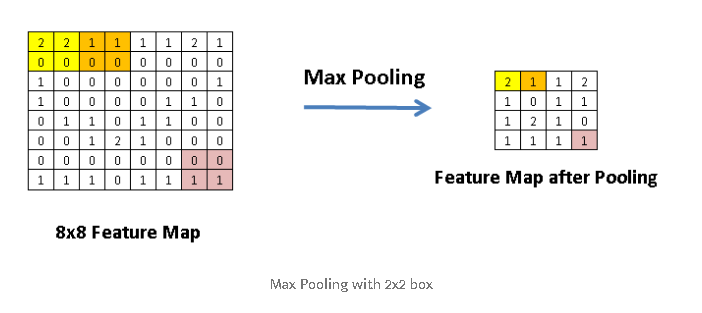

The advantages of pooling:


*   Reducing the size while preserving the features
*   Eliminating parts that are not significant
*   Introducing spatial variance
*   Reducing the number of features and thus reducing the risk of overfitting

Now, we need to flatten pooled feature maps in order to feed them to a fully connected layer. After the flattening step, the structure of the remaining part of a convolutional neural network is just like a feed-forward neural network.

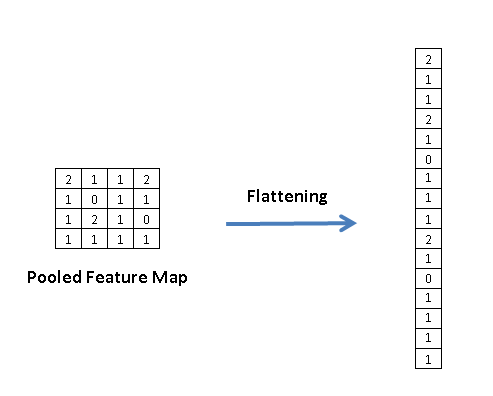

The resulting array after flattening is used as the input to a Dense layer. The pooled feature maps are flattened and fed through a dense layer.

Let's go through an implementation with Keras.





# **Building a Convolutional Neural Network with Keras**

In [12]:
import numpy as np
import tensorflow as tf
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import time
import shutil
import pickle
import pathlib
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
tf.__version__

'2.8.0'

I saved the images to my google drive. In order to directly access the files in the drive from colab, we just need to import drive.

In [13]:
ROOT_DIR = './data'


Let’s check a couple of images using matplotlib:

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [15]:
img = mpimg.imread(
    './data/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg')


In [16]:
type(img)

numpy.ndarray

In [17]:
img.shape

(347, 500, 3)

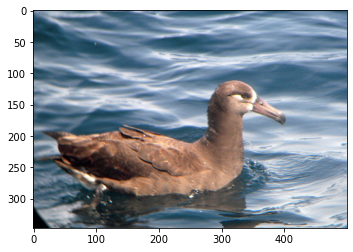

In [18]:
imgplot = plt.imshow(img)

(500, 339, 3)


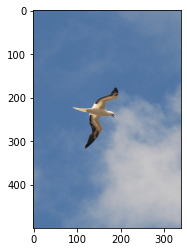

In [19]:
img2 = mpimg.imread(
    './data/images/002.Laysan_Albatross/Laysan_Albatross_0001_545.jpg')
imgplot = plt.imshow(img2)
print(img2.shape)

Images are just arrays of numbers in 2D (grayscale) and 3D (colored). We should also check the structure of an image in addition to seeing how it looks. The first two dimensions show the size of the grid of pixels and the third dimension is indicating if it is colored or grayscale.

You may have noticed the number of pixels are different. The shape of the motorbike image is (161, 262, 3) but the shape of airplane image is (164, 398, 3). The images have to be in the same shape to be used in a CNN. We can manually adjust the sizes but it is a tedious task.

We can use ImageDataGenerator which is an image preprocessing class of Keras. We just need to organize images in a folder structure and ImageDataGenerator will handle the rest.

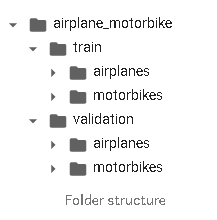

**ImageDataGenerator**

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. ImageDataGenerator creates many batches of the images by applying random selections and transformations (such as rotating and shifting) in batches. So it increases the diversity of the dataset. Data augmentation increases the diversity of data which is very useful especially when the number of images is limited. Increasing the diversity of the dataset helps to get more accurate results and also prevents the model from overfitting.

The images are in the “airplanes” and “motorbikes” folders. I put 640 images of each category in train folder and 160 images in validation folder. Let’s implement ImageDataGenerator objects for both training and validation:

In [97]:
orig_images_folder = 'images'
if os.path.exists('./data/datasets'):
  shutil.rmtree('./data/datasets')
else:
  new_images_folder = 'datasets'
  
  image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(ROOT_DIR, 'images.txt'),
                             header=None,
                             delimiter=' ',
                             nrows=543,
                             names=['Img ID', 'file path'])

  image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(ROOT_DIR, 'train_test_split.txt'),
                                                   header=None, delimiter=' ', nrows=543,
                                                   names=['Img ID', 'is training image?'])['is training image?']
  image_fnames.head()


In [98]:
if os.path.exists('./data/datasets'):
   shutil.rmtree('./data/datasets')

data_dir = os.path.join(ROOT_DIR, orig_images_folder)
new_data_dir = os.path.join(ROOT_DIR, new_images_folder)
os.makedirs(os.path.join(new_data_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir, 'val'), exist_ok=True)

for i_image, image_fname in enumerate(image_fnames['file path']):
    if image_fnames['is training image?'].iloc[i_image]:
        new_dir = os.path.join(new_data_dir, 'train',
                               image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))
    else:
        new_dir = os.path.join(new_data_dir, 'test', image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))

        new_dir = os.path.join(new_data_dir, 'val', image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))

print('prepare dataset structure done.')


prepare dataset structure done.


In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [100]:
train_datagen = ImageDataGenerator(rescale=1/255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [101]:
#File path to the folder containin images
train_dir = os.path.join('./data/datasets/train')
validation_dir = os.path.join('./data/datasets/val')
test_dir = os.path.join('./data/datasets/test')


In [102]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


Found 300 images belonging to 10 classes.
Found 243 images belonging to 10 classes.
Found 243 images belonging to 10 classes.


We used flow_from_directory method. Another option is to use flow method. The details of each method are explained in detail in keras documentation.

Let’s go over the parameters. The first one is the file path which we already created in the previous step. Target_size indicates the size of resulting images. Train and validation generators will resize all images to 150x150 pixels. Batch_size is the number of images in a batch. The class_mode is binary since we have two classes. As we can see in the output, there are 1280 images in train folde and 320 in validation folder belonging to 2 classes.

**Building the Model**

In [103]:
model = tf.keras.models.Sequential([
                                    
    # First convolution layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

We have 3 convolution layers and a pooling layer right after each convolution layer. In the first convolution layer, we define the number of filters and the filter size. I choose to use 16 filters with a size of 3x3. Then we define the activation function which is relu. For the first convolution layers ,we also need to define the input_shape because the model will not know the size of our images. For pooling layer, we only need to specify the size of box used for pooling.

We follow the same procedure for the other convolutional layers. The only difference is that we do not have to specify the input shape because the model will know the input from the output of previous layer.

Then we have flatten layer to flatten pooled feature maps. Flattened feature maps are fed to a Dense layer. Then we have an output layer.

It is important to note that there is not a strict rule to determine number of filters, filter size, number of neurons in a layer and so on. The values for these parameters are adjusted with experience or trial and error. You can adjust and try different values.

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

The size of input images are 150x150. We used 3x3 filters so the size of feature maps are 148x148. The size is reduced to half in the first pooling layer. At each convolution-pooling layer pair, the size is reduced but features in the images are preserved. In this model, we have more than 2 million parameters to train which is a lot. This is a simple image classification task. Imagine the number of parameters to train the model used in very complex tasks.

It is time to compile the model now:

In [105]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

We need to specify the loss function, optimizer and a metric for evaluating the performance. For loss function, binary_crossentropy can be used since this is a binary classification task. There are many optimizers available in Keras, RMSprop and Adam optimizers are commonly used. The metric we are using is accuracy.

Before fitting the data to the model and train it, I will implement a callback which stops the model training process when a predefined accuracy or loss target is achieved. I will implement a callback in the model so that the training is stopped when 99% accuracy is achieved at the end of an epoch.

In [106]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()
# def callbacks():
#     callbacks = [
#         tf.keras.callbacks.ModelCheckpoint(
#             filepath='lstmchar256256128test.h5',
#             monitor='loss',
#             save_best_only=True
#         ),
#         tf.keras.callbacks.EarlyStopping(
#             monitor='loss',
#             min_delta=0,
#             patience=4,
#             mode='auto',
#             baseline=None,
#         )
#     ]
#     return callbacks


In [107]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,  # 640 images / batch_size of 32
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=5,  # 160 images / batch_size of 32
    callbacks=[callbacks]
)



# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(
#                   from_logits=True),
#               metrics=['accuracy'])

# time1 = time.time()
# history = model.fit(train_generator, epochs=20, validation_data=(
#     validation_generator), callbacks=callbacks())

# # Print duration time
# duration_time = time.time() - time1
# if duration_time < 60:
#     print("{} s".format(duration_time))
# else:
#     print("{} min".format(duration_time/60))


Epoch 1/10
10/10 [==============================] - 5s 381ms/step - loss: -13639.2510 - accuracy: 0.1033 - val_loss: -98212.2969 - val_accuracy: 0.1250
Epoch 2/10
10/10 [==============================] - 3s 338ms/step - loss: -487577.2812 - accuracy: 0.1000 - val_loss: -1270734.7500 - val_accuracy: 0.1312
Epoch 3/10
10/10 [==============================] - 3s 342ms/step - loss: -2852804.7500 - accuracy: 0.1000 - val_loss: -5107353.0000 - val_accuracy: 0.1312
Epoch 4/10
10/10 [==============================] - 3s 343ms/step - loss: -8867483.0000 - accuracy: 0.1000 - val_loss: -14537808.0000 - val_accuracy: 0.1312
Epoch 5/10
10/10 [==============================] - 3s 345ms/step - loss: -20320180.0000 - accuracy: 0.1000 - val_loss: -30273380.0000 - val_accuracy: 0.1312
Epoch 6/10
10/10 [==============================] - 3s 347ms/step - loss: -40820108.0000 - accuracy: 0.1000 - val_loss: -58806164.0000 - val_accuracy: 0.1437
Epoch 7/10
10/10 [==============================] - 3s 346ms/ste

The model has reached 99% accuracy in after the fifth epoch which is a great result. Please keep in mind that this is a simple image classification task. We will deal with much more complicated tasks. However, the way to build the network and logic behind is the same. Thus, if we learn the basics well, we can easily adapt to more complicated tasks.

Let's see how accuracy and loss changes as we do more epochs:

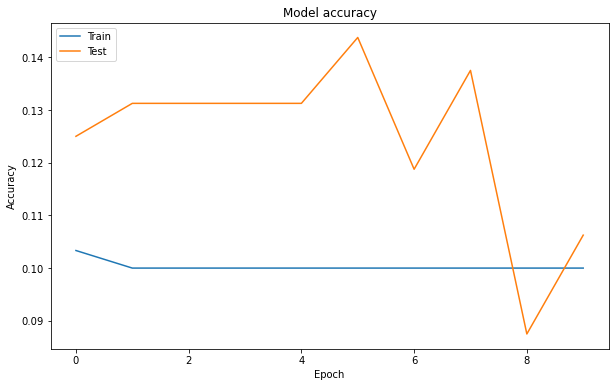

In [108]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

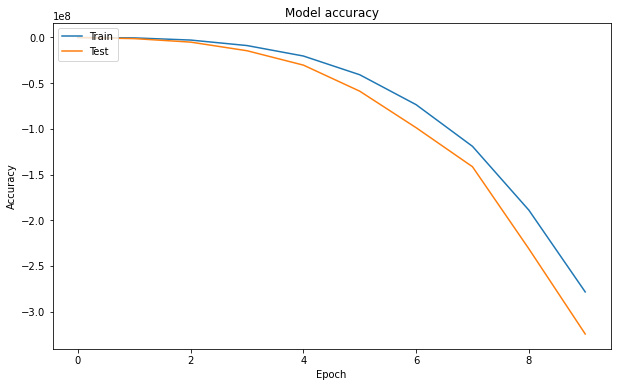

In [109]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [125]:
# pred = model.predict
predictions = model.predict_generator(test_generator, steps=1, verbose=0)
print(predictions)


<ipython-input-125-7efb5eec44c4>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=1, verbose=0)


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [128]:

y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))
print(y_pred)
#plots(test_imgs, titles=y_pred)

ctr = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        ctr = ctr+1
res = ctr/len(y_pred)*100
print(res)


images_classes = pd.read_csv("./data/classes.txt", nrows=9)
predicted_classes = np.argmax(pred, axis=None)
report = classification_report(predicted_classes, y_pred, target_names=images_classes)
print(report)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'y_test' is not defined

It seems like training accuracy has not converged yet. If we do more epochs, we may increase to the training accuracy close to 100%. However, accuracy on the validation set reached 100% after the second epoch.